# About
* 2020-NCAAM & 2020-NCAAW

# Insights

* dart is good accuracy, gdbt is not bad.
* season backward=0 is best?, 3 is bad.

## TODO & Changelog

* Test backward=1,2
  * backward=0 best
* Add Public Ranking score(as ranking) to feature structure.
  * added
* Test dart,gbdt
  * dart is good
* Calibrate preds
  * Add sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
* Test ensamble
  * Use VotingClassifier
* Team Conferences with Conference Game in Men
  * Done
* GridSearch with VotingClassifier
* Team Conferences in Women
* Add Play-by-play to feature structure.
* Inspect Team Coaches.

# Flags

In [1]:
DEBUG=True

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WPlayers.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WEvents2017.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WEvents2019.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WEvents2016.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WEvents2018.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WEvents2015.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneyDetailedResults.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WTeamConferences.csv
/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-wom

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import log_loss, brier_score_loss, plot_roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

# Game result data class
* Season: regular season data
* Tourney: NCAA 64-68 teams per year

In [4]:
class DetailedResult():
    def __init__(self, df):
        self.raw = df

    # location Home/Away/Neutral to int 1/0/-1
    def __get_loc(self,loc,lose=False):
        wloc_to_num = {'H':1, 'A': -1, 'N': 0}
        if loc in wloc_to_num:
            if lose:
                return - wloc_to_num[loc]
            else:
                return wloc_to_num[loc]
        else:
            raise ValueError

    # Wxx Lxx
    def __get_neu_list(self,prefix=''):
        neu_keys = ['TeamID', 'Score', 'Loc', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']
        conv = list(map(lambda x: str(prefix) + x, neu_keys))
        return conv

    def __get_neu_dict(self,prefix=''):
        neu_keys = self.__get_neu_list()
        conv = list(map(lambda x: str(prefix) + x, neu_keys))
        r = dict()
        for n,c in zip(neu_keys,conv):
            r = {**r,c:n}
        return r

    def __get_ren_dict(self,prefix1='',prefix2='T'):
        neu_keys = self.__get_neu_list()
        conv1 = list(map(lambda x: str(prefix1) + x, neu_keys))
        conv2 = list(map(lambda x: str(prefix2) + x, neu_keys))
        r = dict()
        for c1,c2 in zip(conv1,conv2):
            r = {**r,c1:c2}
        return r

    # expand from detail to average and std
    def __get_ave_std_dict(self):
        cols = self.__get_neu_list()
        cols.remove('TeamID')
        cols.append('NumOT')
        d=dict()
        for col in cols:
            d = {**d, col: [np.average,np.std]}
        return d
    
    def get_raw(self):
        return self.raw

    def __loc_norm(self,win_1st):
        # Location flag for Lose team
        win_1st['LLoc'] = win_1st['WLoc'].map(lambda x: self.__get_loc(x,lose=True))
        win_1st['WLoc'] = win_1st['WLoc'].map(lambda x: self.__get_loc(x,lose=False))
        return win_1st
    
    def get_match_result(self, season, backward=0):
        """
        TeamID1,TeamID2,...,result(TeamID1) pair scores and features
        
        Parameters
        ----------
        season: int
            Season
        backword: int
            go back years
        """
        win_1st = self.raw.copy()
        win_1st = win_1st.loc[(win_1st['Season'] <= season) & (win_1st['Season'] >= season-backward)].reset_index(drop=True)
        
        # Location flag for Lose team
        win_1st = self.__loc_norm(win_1st)
        
        # copy lose_1st
        lose_1st = win_1st.copy()
        lose_1st.rename(columns=self.__get_ren_dict('W','T'), inplace=True)
        lose_1st.rename(columns=self.__get_ren_dict('L','W'), inplace=True)
        lose_1st.rename(columns=self.__get_ren_dict('T','L'), inplace=True)
        
        # Add result(1st team)
        win_1st['result'] = 1
        lose_1st['result'] = 0

        # concat win and lose (So agg wiht 1Team only, 2Team is only use for mean)
        merge = pd.concat((win_1st,lose_1st)).reset_index(drop=True)
        _a = merge
        
        _a.rename(columns=self.__get_ren_dict('W','1'), inplace=True)
        _a.rename(columns=self.__get_ren_dict('L','2'), inplace=True)

        # concat
        res = _a
        
        # feature assemble
        res['1Score_diff'] = res['1Score'] - res['2Score']
        res['1FG_rate_diff'] = res['1FGM'] / res['1FGA'] - res['2FGM'] / res['2FGA']
        res['1FG3_rate_diff'] = res['1FGM3'] / res['1FGA3'] - res['2FGM3'] / res['2FGA3']
        res['1FT_rate_diff'] = res['1FTM'] / res['1FTA'] - res['2FTM'] / res['2FTA']
        res['1OR_diff'] = res['1OR'] - res['2OR']
        res['1DR_diff'] = res['1DR'] - res['2DR']
        res['1Ast_diff'] = res['1Ast'] - res['2Ast']
        res['1TO_diff'] = res['1TO'] - res['2TO']
        res['1Stl_diff'] = res['1Stl'] - res['2Stl']
        res['1Blk_diff'] = res['1Blk'] - res['2Blk']
        res['1PF_diff'] = res['1PF'] - res['2PF']
        res = res.groupby(['1TeamID']).agg({'result': np.mean, # win_rate
                                            'NumOT': np.mean,
                                            '1Score': [np.mean,np.std],
                                            '1Score_diff': [np.mean,np.std],
                                            '1Loc': np.mean,
                                            '1FG_rate_diff': np.mean,
                                            '1FG3_rate_diff': np.mean,
                                            '1FT_rate_diff': np.mean,
                                            '1OR_diff':  np.mean,
                                            '1DR_diff': np.mean,
                                            '1Ast_diff':  np.mean,
                                            '1TO_diff': np.mean,
                                            '1Stl_diff':  np.mean,
                                            '1Blk_diff': np.mean,
                                            '1PF_diff': np.mean,
                                           }) # mean with backward season included
        res.columns = ["_".join(x) for x in res.columns.ravel()]
        res = res.rename(columns={'result_mean':'1win_rate'})
        res = res.reset_index()
        return res

    def get_feature_keys(self,prefix=''):
        feature_keys = ['win_rate','Score_mean','Score_std','Score_diff_mean','Score_diff_std','Loc_mean',
                        'FG_rate_diff_mean','FG3_rate_diff_mean','FT_rate_diff_mean','OR_diff_mean', 'DR_diff_mean',
                        'Ast_diff_mean','TO_diff_mean','Stl_diff_mean','Blk_diff_mean','PF_diff_mean']
        conv = list(map(lambda x: str(prefix) + x, feature_keys))
        return conv
    
    def __get_feature_ren_dict(self,prefix1='',prefix2=''):
        feature_keys = ['TeamID',*self.get_feature_keys()]
        conv1 = list(map(lambda x: str(prefix1) + x, feature_keys))
        conv2 = list(map(lambda x: str(prefix2) + x, feature_keys))
        r = dict()
        for c1,c2 in zip(conv1,conv2):
            r = {**r,c1:c2}
        return r
    
    def get_team_feature(self,season,backward=0,prefix=False):
        res = self.get_match_result(season,backward)        
        res = res[['1TeamID',*self.get_feature_keys('1')]]
        res = res.sort_values(by=['1TeamID']).reset_index(drop=True)
        res.rename(columns=self.__get_feature_ren_dict('1',prefix),inplace=True)
        return res 
    
    def get_as_pre_submission(self):
        """
        get as Pre-Submission(TeamID1,TeamID2,result(truth)) format
        
        """
        res = self.raw.copy()
        res['result'] = 1

        # exchange TeamID wiht submission format TeamID1 < TeamID2
        _a = res.loc[res['WTeamID'] < res['LTeamID']]
        _a.rename(columns=self.__get_ren_dict('W','1'), inplace=True)
        _a.rename(columns=self.__get_ren_dict('L','2'), inplace=True)
        _b = res.loc[res['WTeamID'] > res['LTeamID']]
        _b.rename(columns=self.__get_ren_dict('W','2'), inplace=True)
        _b.rename(columns=self.__get_ren_dict('L','1'), inplace=True)

        # result=0 if swaped
        _b['result'] = 0
        
        res = pd.concat((_a,_b)).reset_index(drop=True)
        res.rename(columns={'1TeamID':'TeamID1','2TeamID':'TeamID2'},inplace=True)
        res = res[['Season','TeamID1','TeamID2','result']]
        res = res.sort_values(by=['Season','TeamID1','TeamID2']).reset_index(drop=True)
        
        return res
        
    def get_score(self,prefix=''):
        """
        Single Team scores (for exploration, not use now)
        """
        tmp = self.raw.copy()
        
        # Location flag for Lose team
        tmp = self.__loc_norm(tmp)

        win = tmp[['Season','DayNum', 'NumOT', *self.__get_neu_list('W')]]
        lose = tmp[['Season','DayNum', 'NumOT', *self.__get_neu_list('L')]]

        win.rename(columns=self.__get_neu_dict('W'), inplace=True)
        lose.rename(columns=self.__get_neu_dict('L'), inplace=True)
        
        win[prefix+'Result'] = 1
        lose[prefix+'Result'] = 0

        merge = pd.concat((win,lose)).reset_index(drop=True)
        
        # ave/std
        merge = merge.groupby(['Season', 'TeamID'])
        merge = merge.agg({'DayNum': 'count', prefix+'Result': np.average, **self.__get_ave_std_dict()}).rename(columns={'DayNum': prefix+'Count'})
        
        # rename column with prefix 
        merge.rename(columns=self.__get_ren_dict('', prefix), inplace=True)
        
        return merge

    def get_st_score(self):
        tmp = self.get_score()
        tmp_group = tmp.groupby(['Season', 'TeamID'])
        return tmp_group.agg({'DayNum': 'count', 'Result': np.average, **self.__get_ave_std_dict()}).rename(columns={'DayNum': 'Count'})

# test
def runtest():
    tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    tr = DetailedResult(tourney_result)
    sr = DetailedResult(season_result)
    
    assert tr.get_raw().shape == (1115, 34)
    assert sr.get_raw().shape == (87504, 34)
    
    #return sr.get_team_feature(2019,3,'X')
    assert sr.get_team_feature(2019,3,'X').shape == (353,17)
    
    #return tr.get_as_pre_submission()
    assert tr.get_as_pre_submission().shape == (1115,4)
    
    #return tr.get_match_result(2019,1)
    assert tr.get_match_result(2019,1).shape == (104,18)
    #return tr.get_match_result(2019,1)
    return sr.get_team_feature(2019,3,'X')
if DEBUG:
    runtest()

# Seed data class
1. 1985-2019
2. 64-68 team per year

In [5]:
class Seed():
    def __init__(self,df):
        self.raw = df

    # convert seed W01 to (int)1
    def __get_seed(self,x):
        return int(x[1:3])

    def get_raw(self):
        return self.raw

    def get_seed(self,season=False):
        tmp = self.raw.copy()
        tmp['Seed'] = tmp['Seed'].map(lambda x: self.__get_seed(x))
        if season:
            tmp = tmp.loc[tmp['Season']==season]
        return tmp
        
# test
def runtest1():
    ts = Seed(tourney_seed)
    ts = ts.get_seed()
    sr = DetailedResult(season_result)
    sr = sr.get_match_result(2019,1)
    
    a = pd.merge(ts, sr, left_on=['Season','TeamID'], right_on=['Season','1TeamID'], how='left')
    
    return a

def runtest2():
    tourney_seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    ts = Seed(tourney_seed)
    return ts.get_seed()

if DEBUG:    
    runtest2()
    #a.loc[(a['Season']==2018) & (a['Seed']==1)]
    #a.loc[a['Season'] == 2019].groupby(['TeamID']).mean()

# Public ranking class
* MMasseyOrdinals
* RankingDayNum: 0-133
  * Last RankingDayNum: 133


In [6]:
class MasseyOrdinals():
    def __init__(self,df):
        self.raw = df

    def get_raw(self):
        return self.raw
    
    def get_feature_keys(self):
        l = list(self.get_team_feature().columns)
        l.remove('Season')
        l.remove('TeamID')
        return l

    def __get_systems(self):
        return self.raw['SystemName'].unique()

    def get_team_feature(self,season=False):
        """
        (Season,TeamID, *SystemName)
        (2019, 1111, 12,123,12,1)
        """
        tmp = self.raw.copy()
        tmp = tmp.loc[(tmp['RankingDayNum'] == 133)].drop('RankingDayNum',axis=1)
        tmp = tmp.fillna(0)
        tmp = tmp.groupby(['Season','TeamID','SystemName']).mean()        
        tmp = tmp.unstack()
        tmp.columns = tmp.columns.droplevel()
        tmp = tmp.reset_index()

        if season:
            tmp = tmp.loc[tmp['Season'] == season]
            #tmp = tmp.loc[(season)]
        return tmp

def runtest():
    mo_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MMasseyOrdinals.csv')
    mo = MasseyOrdinals(mo_df)
    #assert mo.get_raw().shape == (3820919,5)
    #assert mo.get_team_feature().shape == (5833, 164)
    #assert mo.get_team_feature(2010).shape == (347, 164)
    #assert mo.get_team_feature(2014).shape == (351, 164)
    return mo.get_team_feature(2014)

def runtest1():
    mo_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MMasseyOrdinals.csv')
    mo = MasseyOrdinals(mo_df)
    return mo.get_feature_keys()

if DEBUG:
    a = runtest1()
    #a = runtest()
    #a.loc[(2010)]
    a
    #a.loc[a['SystemName'] == 'BBT'].sort_values(['OrdinalRank'])
    #a.loc[a['TeamID'] == 1181].sort_values(['OrdinalRank'])
    #a.loc[a['TeamID'] == 1181]

    #df = a.loc[(2019,1101)] - a.loc[(2019,1102)]
    #df.add_prefix('1').add_suffix('__diff')

    #df = pd.merge(df1,df2,on=['Season'])
    #df
    #a.columns
    #a.index
    #a.add_prefix('1_')

# Team Conference Class

In [7]:
class TeamConference():
    def __init__(self,tc_df,ctg_df):
        self.raw_tc = tc_df
        self.raw_ctg = ctg_df

    def get_feature_keys(self):
        l = list(self.get_team_feature().columns)
        l.remove('Season')
        l.remove('TeamID')
        return l
    
    def get_team_feature(self,season=False):
        __tc = self.raw_tc.copy()
        __tc = pd.get_dummies(__tc,dtype=np.int8)
        if season:
            __tc = __tc.loc[__tc['Season']==season]
        __tmp = self.get_match_result(season)        
        __tmp = pd.merge(__tc, __tmp, on=['Season','TeamID'],how='left')
        #__tmp = __tmp.sort_values(by=['1TeamID']).reset_index(drop=True)
        #__tmp.rename(columns=self.__get_feature_ren_dict('1',prefix),inplace=True)
        return __tmp
    
    def get_match_result(self,season=False):
        __tmp = pd.DataFrame()
        win_1st = self.raw_ctg.rename(columns={'WTeamID':'TeamID'}).drop(['DayNum','LTeamID'],axis=1)
        win_1st['result'] = 1
        lose_1st = self.raw_ctg.rename(columns={'LTeamID':'TeamID'}).drop(['DayNum','WTeamID'],axis=1)
        lose_1st['result'] = 0
        __tmp = pd.concat((win_1st,lose_1st)).reset_index(drop=True)
        if season:
            __tmp = __tmp.loc[__tmp['Season']==season]
        __tmp = __tmp.groupby(['Season','TeamID']).agg({'result': [np.mean,np.std]})
        __tmp.columns = ["_".join(x) for x in __tmp.columns.ravel()]
        return __tmp.reset_index()
    
    
def runtest():
    tc_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeamConferences.csv')
    ctg_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MConferenceTourneyGames.csv')
    tc = TeamConference(tc_df,ctg_df)
    assert tc.get_match_result(2007).shape == (294,4)
    assert tc.get_team_feature(2007).shape == (336,55)
    assert tc.get_team_feature(2012).shape == (345,55)
    assert tc.get_team_feature(2017).shape == (351,55)
    #return tc.get_team_feature(2019)
    return tc.get_feature_keys()

if DEBUG:
    runtest()
        

# Submission data class
1. Seed 68 team means that 67 pertterns match pairs per year.
2. Stage1 2015-2019 seed teams, predict by history that 2003-2019 season games and 2003-2019 tourney games.
3. Stage2 2020 seed teams, predict by history that 2015-2020 season games and 2015-2019 tourney games.
   PRED results of 2020 seed menbers pair, FROM 2020 season games score and results AND 2019 tourny games.

PRED results of Y seed menbers pair, FROM Y-12 to Y season games score and results AND Y-11 to Y-1 tourny games.


In [8]:
class Submission():
    """
    Submission class
    
    Fields
    ------
    ID : str
        from csv field
    Season : int
        2019 etc
    TeamID1 : int
    TeamID2 : int
    Pred : float
        TeamID1 win rate
    """
    def __init__(self,df):
        self.raw = df

    def __separate_id(self):
        tmp = self.raw.copy()
        tmp['Season'] = tmp['ID'].map(lambda x: int(x[:4]))
        tmp['TeamID1'] = tmp['ID'].map(lambda x: int(x[5:9]))   # rate: Pred
        tmp['TeamID2'] = tmp['ID'].map(lambda x: int(x[10:14])) # rate: 1-Pred
        return tmp

    def get_raw(self):
        return self.raw
    
    def get_separated(self):
        return self.__separate_id()
    
    def get_as_pre_submission(self):
        """
        get as pre-submission format
        """
        res = self.get_separated()
        return res[['Season','TeamID1','TeamID2']]
    
    def get_with_result(self, detail_result):
        """
        get df Join on Season,Temaid with result
        """
        submit = self.get_separated()
        submit = pd.merge(submit, detail_result.get_score('1'), left_on=['Season','TeamID1'], right_on=['Season', 'TeamID'], how='left')
        submit = pd.merge(submit, detail_result.get_score('2'), left_on=['Season','TeamID2'], right_on=['Season', 'TeamID'], how='left')
        submit = submit.drop(['ID','Pred','TeamID1','TeamID2'],axis=1)
        return submit

# test
def runtest1(): # with feature
    test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
    sm = Submission(test_df)
    sm = sm.get_separated()
    sr = DetailedResult(season_result)
    ts = Seed(tourney_seed)
    
    r = pd.DataFrame([])
    for season in sm['Season'].unique():
        _sm = sm.loc[sm['Season'] == season].reset_index(drop=True) # 1 season
        _ts = ts.get_seed(season)
        _sr1 = sr.get_team_feature(season,1,'1') # many season feature mean
        _sr2 = sr.get_team_feature(season,1,'2') # many season feature mean
        
        tmp = pd.merge(_sm, _ts, left_on=['Season','TeamID1'], right_on=['Season','TeamID'], how='left').rename(columns={'Seed': 'Seed1'}).drop(['TeamID'],axis=1)
        tmp = pd.merge(tmp, _ts, left_on=['Season','TeamID2'], right_on=['Season','TeamID'], how='left').rename(columns={'Seed': 'Seed2'}).drop(['TeamID'],axis=1)
        tmp = pd.merge(tmp, _sr1, left_on=['TeamID1'], right_on=['1TeamID'], how='left')
        tmp = pd.merge(tmp, _sr2, left_on=['TeamID2'], right_on=['2TeamID'], how='left')
        
        tmp.drop(['1TeamID','2TeamID'],axis=1)
        tmp['1win_diff'] = tmp['1win_rate'] - tmp['2win_rate']
        tmp['1score_diff'] = tmp['1score_mean'] - tmp['2score_mean']
        tmp['1seed_diff'] = tmp['Seed1'] - tmp['Seed2']
        r = r.append(tmp)
    return r

def runtest2():
    test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
    
    s1 = Submission(test_df)
    return s1.get_separated()
def runtest3():
    test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
    
    s1 = Submission(test_df)
    assert s1.get_as_pre_submission().shape == (11390, 3)
    assert s1.get_separated().shape == (11390, 5)
    return s1.get_separated()
    
if DEBUG:    
    a = runtest3()
    a
    #a.sort_values(by=['result'])


# Preparing train data
1. TourneyResults(WTeamID,LTeamID,result) to pre-Submission(Season,TeamID1,TeamID2,result)
2. Join Submission(TeamID1,TeamID2,result) in tourney_season=Y and SeasonFeatures(TeamID,features..) in season between Y and Y-backward as Team1 and Team2


In [9]:
class Prepare():
    def __init__(self,
                 tourney_result,
                 season_result,
                 tourney_seed,
                 test_df,
                 massey_ordinals=None,
                 team_conference=None,
                 conference_tourney_game=None
                ):
        self.backward = 0  # season feature backward
        self.tr = DetailedResult(tourney_result)
        self.sr = DetailedResult(season_result)
        self.ts = Seed(tourney_seed)
        self.s1 = Submission(test_df)
        
        if massey_ordinals is not None:
            self.mo = MasseyOrdinals(massey_ordinals)
        else:
            self.mo = None

        if (team_conference is not None) and (conference_tourney_game is not None):
            self.tc = TeamConference(team_conference,conference_tourney_game)
        else:
            self.tc = None

    def __prepare_df(self,ps):
        r = pd.DataFrame()
        for season in ps['Season'].unique():
            _ps = ps.loc[ps['Season'] == season].reset_index(drop=True) # 1 season
            _sr1 = self.sr.get_team_feature(season,self.backward,'1') # many season feature mean
            _sr2 = self.sr.get_team_feature(season,self.backward,'2') # many season feature mean    
            _ts = self.ts.get_seed(season)
            
            _tmp = pd.merge(_ps, _ts, left_on=['Season','TeamID1'], right_on=['Season','TeamID'], how='left').rename(columns={'Seed': 'Seed1'}).drop(['TeamID'],axis=1)
            _tmp = pd.merge(_tmp, _ts, left_on=['Season','TeamID2'], right_on=['Season','TeamID'], how='left').rename(columns={'Seed': 'Seed2'}).drop(['TeamID'],axis=1)
            _tmp = pd.merge(_tmp, _sr1, left_on=['TeamID1'], right_on=['1TeamID'], how='left').drop(['1TeamID'],axis=1)
            _tmp = pd.merge(_tmp, _sr2, left_on=['TeamID2'], right_on=['2TeamID'], how='left').drop(['2TeamID'],axis=1)
            if self.mo:
                _mo = self.mo.get_team_feature(season)
                _tmp = pd.merge(_tmp, _mo.add_prefix('1'), left_on=['Season','TeamID1'], right_on=['1Season','1TeamID'], how='left').drop(['1Season','1TeamID'],axis=1)
                _tmp = pd.merge(_tmp, _mo.add_prefix('2'), left_on=['Season','TeamID2'], right_on=['2Season','2TeamID'], how='left').drop(['2Season','2TeamID'],axis=1)
            if self.tc:
                _tc = self.tc.get_team_feature(season)
                _tmp = pd.merge(_tmp, _tc.add_prefix('1'), left_on=['Season','TeamID1'], right_on=['1Season','1TeamID'], how='left').drop(['1Season','1TeamID'],axis=1)
                _tmp = pd.merge(_tmp, _tc.add_prefix('2'), left_on=['Season','TeamID2'], right_on=['2Season','2TeamID'], how='left').drop(['2Season','2TeamID'],axis=1)

            # tourney feat diff
            for ft in self.tr.get_feature_keys(): # + self.mo.get_feature_keys():
                _tmp['1'+ft+'__diff'] = _tmp['1'+ft] - _tmp['2'+ft]
                _tmp = _tmp.drop(['1'+ft,'2'+ft],axis=1)
            
            # massey ordinals day133 diff
            if self.mo:
                for ft in self.mo.get_feature_keys():
                    _tmp['1'+ft+'__diff'] = _tmp['1'+ft] - _tmp['2'+ft]
                    _tmp = _tmp.drop(['1'+ft,'2'+ft],axis=1)

            # conference diff
            if self.tc:
                for ft in self.tc.get_feature_keys():
                    _tmp['1'+ft+'__diff'] = _tmp['1'+ft] - _tmp['2'+ft]
                    _tmp = _tmp.drop(['1'+ft,'2'+ft],axis=1)
            
            # seed diff
            _tmp['1Seed__diff'] = _tmp['Seed1'] - _tmp['Seed2']
            _tmp = _tmp.drop(['Seed1','Seed2'],axis=1)
            
            r = r.append(_tmp)

        return r.sort_values(by=['Season','TeamID1','TeamID2']).reset_index(drop=True)

    def __drop_list(self):
        #return ['Season','TeamID1','TeamID2','1win_rate','2win_rate','1score_mean','2score_mean','Seed1','Seed2']
        return ['Season','TeamID1','TeamID2']
        
    def get_pre_train(self):
        ps = self.tr.get_as_pre_submission()
        res = self.__prepare_df(ps)
        X = res.drop('result',axis=1)
        y = res.result
        return X,y
      
    def get_train(self):
        X,y = self.get_pre_train()
        return X.drop(self.__drop_list(),axis=1), y
    
    def get_pre_test(self):
        ps = self.s1.get_as_pre_submission()
        X = self.__prepare_df(ps)
        return X
    
    def get_test(self):
        X = self.get_pre_test()
        return X.drop(self.__drop_list(),axis=1)
    

def runtest():
    tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    tourney_seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
    massey_ordinals = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MMasseyOrdinals.csv')
    tc_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeamConferences.csv')
    ctg_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MConferenceTourneyGames.csv')

    pre0 = Prepare(tourney_result,season_result,tourney_seed,test_df)
    X,y = pre0.get_pre_train()
    assert X.shape == (1115, 20)
    assert y.shape == (1115,)
    X,y = pre0.get_train()
    assert X.shape == (1115, 17)
    assert y.shape == (1115,)
    X = pre0.get_test()
    assert X.shape == (11390, 17)
    #return X    
    
    pre = Prepare(tourney_result,season_result,tourney_seed,test_df,massey_ordinals)

    X,y = pre.get_pre_train()
    #return X
    assert X.shape == (1115, 184)
    assert y.shape == (1115,)
    assert pre.get_pre_test().shape == (11390, 184)

    X,y = pre.get_train()
    #return X
    assert X.shape == (1115, 181)
    assert y.shape == (1115,)
    
    X = pre.get_test()
    assert X.shape == (11390, 181)
    #return X

    
    pre = Prepare(tourney_result,season_result,tourney_seed,test_df,None,tc_df,ctg_df)
    X,y = pre.get_pre_train()
    assert X.shape == (1115, 73)
    X,y = pre.get_train()
    assert X.shape == (1115, 70)
    
    pre = Prepare(tourney_result,season_result,tourney_seed,test_df,massey_ordinals,tc_df,ctg_df)
    X,y = pre.get_pre_train()
    assert X.shape == (1115, 237)
    X,y = pre.get_train()
    assert X.shape == (1115, 234)

if DEBUG:
    a =runtest()
    #list(a.columns)
    a

# Load X,y,X_test

In [10]:
def load_men():
    tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
    season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
    tourney_seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')
    test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
    massey_ordinals = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MMasseyOrdinals.csv')
    tc_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeamConferences.csv')
    ctg_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MConferenceTourneyGames.csv')
    pre = Prepare(tourney_result,season_result,tourney_seed,test_df,massey_ordinals,tc_df,ctg_df)
    pre.backward = 0 # 3 season history backward not works.
    X,y = pre.get_train()
    X_test = pre.get_test()
    return X,y,X_test

def load_women():
    tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneyDetailedResults.csv')
    season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WRegularSeasonDetailedResults.csv')
    tourney_seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WNCAATourneySeeds.csv')
    test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv')
    #massey_ordinals = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WMasseyOrdinals.csv')
    #tc_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WTeamConferences.csv')
    #ctg_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WDataFiles_Stage1/WConferenceTourneyGames.csv')
    pre = Prepare(tourney_result,season_result,tourney_seed,test_df)
    pre.backward = 0 # 3 season history backward not works.
    X,y = pre.get_train()
    X_test = pre.get_test()
    return X,y,X_test

# Model tuning
* load X,y,X_test from load_men() or load_women()
* get best parameter with seach_params()

In [11]:
def search_params(X,y):
    X_train, X_eval, y_train, y_eval = train_test_split(X,y,test_size=0.2)
    params = {
        'device_type': 'cpu', # gpu (experimental)
        'num_threads': 4,
        'objective': 'binary',
        'metric': ['binary_logloss'],

        ### gbdt
        #'early_stopping_rounds': 32, # 8  
        #'num_iterations': 2000,    # 100 large
        #'learning_rate': 1e-02, #stats.loguniform(1e-05, 3e-04),    # 0.1 accuracy/overfitting
        #'boosting_type': 'gbdt', # gbdt(2e-03) dart(1e-02) # accuracy
        #'max_depth': 3,
        #'num_leaves': 5,

        ### dart
        'random_state': 0,
        'num_iterations': 2000,    # 100 large
        'learning_rate': 2e-02, # 0.1 small
        'boosting_type': 'dart', # gbdt(2e-03) dart(1e-02)
        'max_depth': 3,
        'num_leaves': 5,
        #'max_bin': 800, #stats.randint(255,2000),           # 255 500
        
        
    }
    grid_params = {   

        ### dart
        #'num_leaves': stats.randint(1,10), # 31 accuracy/overfitting 22
        #'max_drop': [78], #stats.randint(40, 90), # 50 80
        #'drop_rate': [0.06], #stats.uniform(0.0, 0.4), # 0.1 0.03
        #'skip_drop': [0.117], #stats.uniform(0.0, 0.5), # 0.5

        ### vs. overfitting like regularization

        ## 1st tuning -- depend on #data
        #'max_depth': stats.randint(1,4),  # -1
        #'min_data_in_leaf': stats.randint(2,14), # 20 fixed of/uf
        
        ## 2nd tuning -- 2^(max_depth-1) < n < 2^(max_depth)
        #'num_leaves': stats.randint(1,10), # 31 acc/of
        
        ## 3rd tuning -- accuracy
        #'max_bin': stats.randint(250,1200), # 255 acc/of

        ## 4th tuning
        #'bagging_fraction': [0.785], #stats.uniform(0.5, 0.4), # 1.0 0.8
        #'bagging_freq': [1], # 0
        #'extra_trees': [True], # False

        
        ## 5th tuning
        #'feature_fraction': stats.uniform(0.1, 0.9), # 1.0 like dropout
        #'lambda_l1': stats.uniform(0.0, 1.0), # 0.0 0.85
        #'lambda_l2': [0.49], #stats.uniform(0.2, 0.5), # 0.0 0.35
        #'min_gain_to_split': stats.uniform(0.0, 0.5), # 0.0 0.25


    }
    clf = lgb.LGBMClassifier(**params)
    gs = RandomizedSearchCV(
        clf,
        grid_params,
        n_iter=10,
        cv = KFold(n_splits=5, shuffle=True, random_state=params['random_state']),
        scoring='neg_log_loss',
        random_state=params['random_state'],
        refit=True)
    gs.fit(X_train, y_train,eval_set=[(X_eval,y_eval)],verbose=100)
    
    # plot logloss
    lgb.plot_metric(gs.best_estimator_,'binary_logloss')

    # calibration
    iso_clf = CalibratedClassifierCV(gs.best_estimator_, method="isotonic", cv='prefit')
    iso_clf.fit(X_eval, y_eval)
    sig_clf = CalibratedClassifierCV(gs.best_estimator_, method="sigmoid", cv='prefit')
    sig_clf.fit(X_eval, y_eval)
    
    # y_preds
    y_preds_raw = gs.best_estimator_.predict_proba(X_eval)[:, 1]
    y_preds_iso = iso_clf.predict_proba(X_eval)[:, 1]
    y_preds_sig = sig_clf.predict_proba(X_eval)[:, 1]

    print('Best -logloss score:\t{:.4}'.format(gs.best_score_))
    print('Best estimator score:\t{:.4}'.format(log_loss(y_eval,y_preds_raw)))
    print('Isotonic score:\t\t{:.4}'.format(log_loss(y_eval,y_preds_iso)))
    print('Sigmoid  score:\t\t{:.4}'.format(log_loss(y_eval,y_preds_sig)))
    
    return gs.best_estimator_.get_params()

[100]	valid_0's binary_logloss: 0.529255
[200]	valid_0's binary_logloss: 0.49292
[300]	valid_0's binary_logloss: 0.467708
[400]	valid_0's binary_logloss: 0.452473
[500]	valid_0's binary_logloss: 0.445548
[600]	valid_0's binary_logloss: 0.439584
[700]	valid_0's binary_logloss: 0.429486
[800]	valid_0's binary_logloss: 0.425781
[900]	valid_0's binary_logloss: 0.421133
[1000]	valid_0's binary_logloss: 0.419456
[1100]	valid_0's binary_logloss: 0.419616
[1200]	valid_0's binary_logloss: 0.417082
[1300]	valid_0's binary_logloss: 0.415401
[1400]	valid_0's binary_logloss: 0.414307
[1500]	valid_0's binary_logloss: 0.411745
[1600]	valid_0's binary_logloss: 0.410463
[1700]	valid_0's binary_logloss: 0.410279
[1800]	valid_0's binary_logloss: 0.409053
[1900]	valid_0's binary_logloss: 0.411772
[2000]	valid_0's binary_logloss: 0.413706
[100]	valid_0's binary_logloss: 0.543448
[200]	valid_0's binary_logloss: 0.503067
[300]	valid_0's binary_logloss: 0.477939
[400]	valid_0's binary_logloss: 0.46171
[500]	v

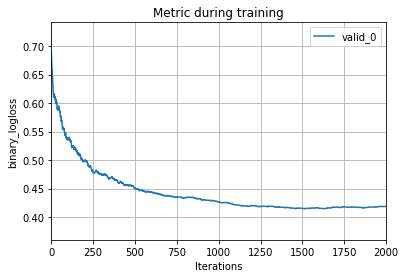

In [12]:
if DEBUG:
    X,y,X_test = load_women()
    param = search_params(X,y)
    print(param)

## Calculated params

In [13]:
param_dart_women={
    'boosting_type': 'dart',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.03,
    'max_depth': 2,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 3,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    'num_iterations': 1000}
param_gbdt_women={
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 5,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    #'early_stopping_rounds': 32,
    'num_iterations': 280,
    'max_bin': 946}
param_dart_men={
    'boosting_type': 'dart',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.03,
    'max_depth': 2,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 3,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    'num_iterations': 400,
    'max_bin': 800,
    'bagging_fraction': 0.785,
    'bagging_freq': 1,
    'extra_trees': True,
    'lambda_l2': 0.4971122519867125}
param_gbdt_men ={
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.01,
    'max_depth': 2,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 3,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    #'early_stopping_rounds': 32,
    'num_iterations': 2000}
_param_gbdt_men ={
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.0003,
    'max_depth': 3,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    #'early_stopping_rounds': 10,
    'num_iterations': 15000, #10000
    'max_bin': 1500,
    'bagging_fraction': 0.8,
    'bagging_freq': 0,
    'extra_trees': True,
    'feature_fraction': 0.14942781480062634,
    'lambda_l2': 0.6502883645891266,    
    'min_data_in_leaf': 82}
_param_gbdt_women ={
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.0003,
    'max_depth': 3,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    #'early_stopping_rounds': 10,
    'num_iterations': 15000, #11000
    'max_bin': 1500,
    'bagging_fraction': 0.85,
    'bagging_freq': 0,    
    'extra_trees': True,
    'feature_fraction': 0.7141384275200073,
    'lambda_l2': 0.2104430671327452,
    'min_data_in_leaf': 36}
_param_dart_men={
    'boosting_type': 'dart',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.003,
    'max_depth': 2,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 37,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    'num_iterations': 10000,
    'bagging_fraction': 0.33,
    'bagging_freq': 1,
    'drop_rate': 0.084,
    'extra_trees': True,
    'feature_fraction': 0.10860473134218412,
    'lambda_l1': 0.7489177872134295,
    'lambda_l2': 0.4110745835653511,
    'max_bin': 883,
    'max_drop': 88,
    'min_gain_to_split': 0.416577843839325,
    'skip_drop': 0.35}
param_dart_women={
    'boosting_type': 'dart',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.005,
    'max_depth': 5,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    #'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'device_type': 'cpu',
    'num_threads': 4,
    'metric': ['binary_logloss'],
    'num_iterations': 12500,
    'max_bin': 1600,
    'bagging_fraction': 0.656,
    'bagging_freq': 1,
    'drop_rate': 0.06,
    'extra_trees': True,
    'feature_fraction': 0.5041555816486761,
    'lambda_l1': 0.14348565828538462,
    'lambda_l2': 0.03137365290350269,
    'max_drop': 78,
    'min_data_in_leaf': 23,
    'min_gain_to_split': 0.29629331241595064,
    'skip_drop': 0.117}

# Voting function

In [14]:
 
def voting(X,y,gbdt_params=None,dart_params=None):
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    log_losses = defaultdict(list)
    
    for train_index,eval_index in tqdm(list(skf.split(X,y))):
        X_train, X_eval = X.iloc[train_index], X.iloc[eval_index]
        y_train, y_eval = y[train_index], y[eval_index]
        if gbdt_params is None:
            gbdt_params = {    
                'device_type': 'cpu', # gpu (experimental)
                'num_threads': 4,
                'objective': 'binary',
                'metric': ['binary_logloss'],
                'num_iterations': 25000,    # 100 large
                'learning_rate': 3e-04, #stats.loguniform(1e-05, 3e-04),    # 0.1 accuracy/overfitting
                'boosting_type': 'gbdt', # gbdt(2e-03) dart(1e-02) # accuracy
                'max_bin': 1500, #stats.randint(1000,1800), # 255 accuracy/overfitting
            }
        if dart_params is None:
            dart_params = {
                'device_type': 'cpu', # gpu (experimental)
                'num_threads': 4,
                'objective': 'binary',
                'metric': ['binary_logloss'],
                'num_iterations': 4000,    # 100 large
                'learning_rate': 3e-03, # 0.1 small
                'boosting_type': 'dart', # gbdt(2e-03) dart(1e-02)
                'max_bin': 255, #stats.randint(1000,2000),           # 255 500
                'num_leaves': 22, #stats.randint(40,120), # 31 accuracy/overfitting 22
                'max_drop': 80, # 50
                'drop_rate': 0.03, #stats.uniform(0.0, 1.0), # 0.1
                'skip_drop': 0.5, #stats.uniform(0.3, 0.4), # 0.5
            }

        estimators = [
            ('lgb1', lgb.LGBMClassifier(**gbdt_params,random_state=0)),
            ('lgb2', lgb.LGBMClassifier(**dart_params,random_state=1)),
            ('lgb3', lgb.LGBMClassifier(**gbdt_params,random_state=2)),
            ('lgb4', lgb.LGBMClassifier(**dart_params,random_state=3)),
            ('lgb5', lgb.LGBMClassifier(**gbdt_params,random_state=4)),
            ('lgb6', lgb.LGBMClassifier(**dart_params,random_state=5)),
        ]

        voting = VotingClassifier(estimators,voting='soft')
        voting.fit(X_train,y_train)
        
        y_preds = voting.predict_proba(X_eval)
        score = log_loss(y_eval,y_preds)
        log_losses['voting'].append(score)

        sig_voting = CalibratedClassifierCV(voting, method="sigmoid", cv='prefit')
        sig_voting.fit(X_eval, y_eval)

        y_preds_sig = sig_voting.predict_proba(X_eval)
        score_sig = log_loss(y_eval,y_preds_sig)
        log_losses['sig_voting'].append(score_sig)
        
        for name, estimator in voting.named_estimators_.items():
            y_preds = estimator.predict_proba(X_eval)
            ll = log_loss(y_eval,y_preds)
            log_losses[name].append(ll)
        
    for name, ll_list in log_losses.items():
        mean_ll = np.array(ll_list).mean()
        print(name, ':', mean_ll)

    return sig_voting


# Mens
## Voting model train, predict and submit

In [15]:
X,y,X_test = load_men()
sig_voting = voting(X,y,param_gbdt_men,param_dart_men)
#sig_voting = voting(X,y)

100%|██████████| 5/5 [00:44<00:00,  8.86s/it]

voting : 0.5626537641874096
sig_voting : 0.5645814307074288
lgb1 : 0.587163284532555
lgb2 : 0.5570055059220828
lgb3 : 0.587163284532555
lgb4 : 0.558903065958353
lgb5 : 0.587163284532555
lgb6 : 0.5581443369765068


In [16]:
y_preds_sig = sig_voting.predict_proba(X_test)[:, 1]
test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
test_df['Pred'] = y_preds_sig
test_df

,ID,Pred
0,2015_1107_1112,0.135947
1,2015_1107_1116,0.150710
2,2015_1107_1124,0.149545
3,2015_1107_1125,0.540546
4,2015_1107_1129,0.205941
...,...,...
11385,2019_1449_1459,0.305608
11386,2019_1449_1463,0.808478
11387,2019_1458_1459,0.490232
11388,2019_1458_1463,0.859346


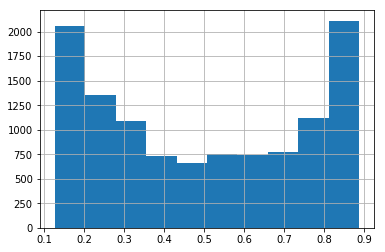

In [17]:
test_df['Pred'].hist()

In [18]:
test_df.to_csv('submission_m.csv', index=False)

# Womens
## Voting model train, predict and submit

In [19]:
X,y,X_test = load_women()
sig_voting = voting(X,y,param_gbdt_women,param_dart_women)

100%|██████████| 5/5 [09:09<00:00, 109.85s/it]

voting : 0.45570631932714034
sig_voting : 0.45513797091210406
lgb1 : 0.4549936688149524
lgb2 : 0.4598518340588895
lgb3 : 0.4549936688149524
lgb4 : 0.46042003976858153
lgb5 : 0.4549936688149524
lgb6 : 0.4618051619665479


In [20]:
y_preds_sig = sig_voting.predict_proba(X_test)[:, 1]
test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament/WSampleSubmissionStage1_2020.csv')
test_df['Pred'] = y_preds_sig
test_df

,ID,Pred
0,2015_3106_3107,0.206499
1,2015_3106_3110,0.333097
2,2015_3106_3113,0.050268
3,2015_3106_3114,0.176381
4,2015_3106_3116,0.303490
...,...,...
10075,2019_3413_3417,0.075464
10076,2019_3413_3460,0.691755
10077,2019_3416_3417,0.135596
10078,2019_3416_3460,0.493296


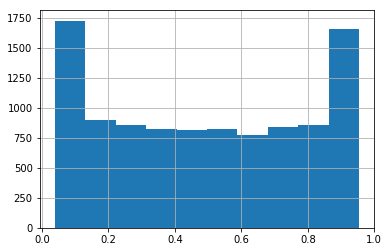

In [21]:
test_df['Pred'].hist()

In [22]:
test_df.to_csv('submission_w.csv', index=False)